# Integration with adult Pan-immune data (v2) - Lymphoid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys,os
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

Global seed set to 0


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scvelo as scv

In [4]:
## import utils
cwd = '../utils/scArches_utils'
sys.path.append(cwd)

import map_query_utils

In [5]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython


In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
def _plot_sorted_violin(merged_adata_bcells, groupby, y_value):
    n_cells_anno = merged_adata_bcells.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = merged_adata_bcells.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    merged_adata_bcells.var_names_make_unique()
    plt.rcParams["figure.figsize"] = [14,6]
    sc.pl.violin(merged_adata_bcells[merged_adata_bcells.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)

In [9]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/fetalVSadult_lymphoid_v2/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir


### Save LYMPHOID scVI model with EnsemblIDs

In [29]:
split = "LYMPHOID"
scvi_outs_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'

## Read old varnames
model_dir='scvi_' + split + '_model/'
var_names_model = pd.read_csv(scvi_outs_dir + model_dir + "var_names.csv", header=None)[0].values

## Make new model folder for model with EnsemblIDs
new_model_dir = model_dir.strip("/") +"_ENSID/"
bash_call = 'cp -r {o} {n}'.format(o=scvi_outs_dir + model_dir, n=scvi_outs_dir+new_model_dir)
os.system(bash_call)

## Save var_names
adata_ref_var = pd.read_csv(scvi_outs_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.var.csv'.format(t=timestamp, s=split), index_col=0)
adata_ref_var.iloc[var_names_model]['GeneID'].to_csv(scvi_outs_dir + new_model_dir + "var_names.csv", header=None, index=False)

### Train on scVI models

On GPU node, running the call:

We merge datasets and rerun embeddings running

### Load output

In [10]:
merged_adata_file = 'panimmune_full_LYMPHOID_query.mapped2LYMPHOID_NEW.withReference.h5ad'
split = "LYMPHOID_NEW"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
data_dir ="/nfs/team205/ed6/data/Fetal_immune/"

In [11]:
merged_adata = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [12]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
exclude_obs = reference_obs[reference_obs.str.strip("-reference").isin(mat_barcodes)]

merged_adata = merged_adata[~merged_adata.obs_names.isin(exclude_obs)].copy()

In [13]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

merged_adata.obs["organ"] = np.nan
merged_adata.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values

merged_adata.obs["age"] = np.nan
merged_adata.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

In [14]:
## Add metadata and annotations for the query
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
query_anno_obs = merged_adata[query_obs].obs.copy()
merged_adata.obs["annotation_query"] = np.nan
df = query_anno_obs.loc[query_obs][["Category"]].astype("str").replace("nan", np.nan)

In [15]:
merged_adata.obs.loc[query_obs, "annotation_query"] = df["Category"].loc[query_obs].values

# merged_adata.obs["organ_code"] = np.nan
# merged_adata.obs.loc[query_obs, "organ_code"] = query_anno_obs.loc[query_obs.str.strip("-query")]["organ code"].values

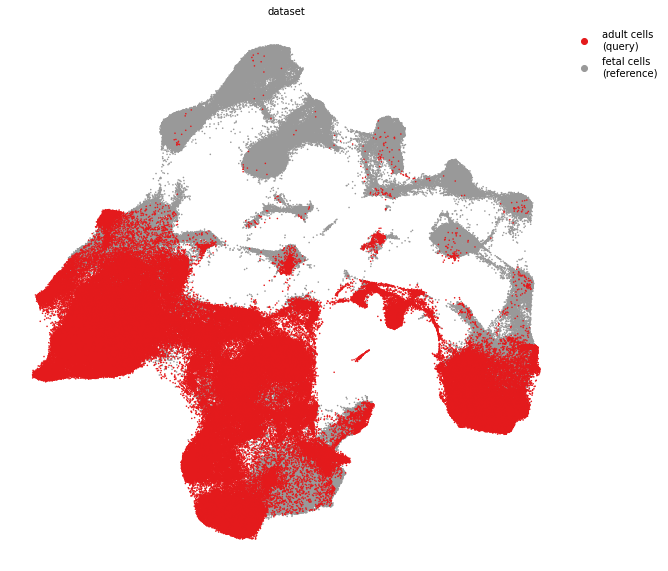

In [16]:
plt.rcParams["figure.figsize"] = [10,10]
merged_adata.obs['dataset_pl'] = ['fetal cells\n(reference)' if x=='reference' else 'adult cells\n(query)' for x in merged_adata.obs['dataset']]
scv.pl.umap(merged_adata, color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )

Trying to set attribute `.uns` of view, copying.


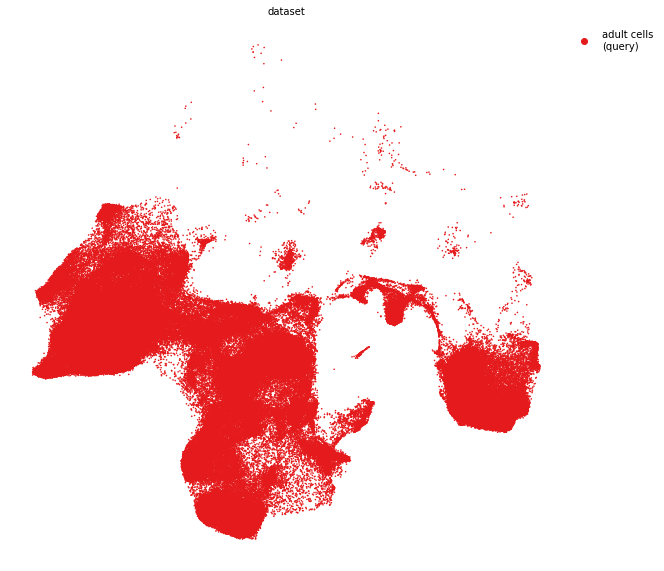

Trying to set attribute `.uns` of view, copying.


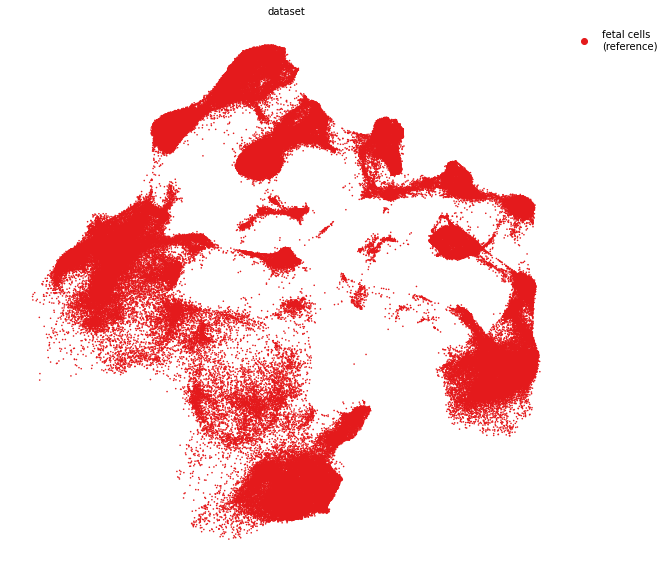

In [18]:
scv.pl.umap(merged_adata[merged_adata.obs['dataset'] == 'query'], color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )
scv.pl.umap(merged_adata[merged_adata.obs['dataset'] == 'reference'], color=["dataset_pl"], size=10, palette='Set1', frameon=False, title='dataset',  
#             save="dataset_q2r.pdf"
           )

In [17]:
merged_adata.obs["dataset"].value_counts()

query        264929
reference    239355
Name: dataset, dtype: int64

### Plot query and reference annotations

In [20]:
anno_labels_pl = {
    'Tnaive/CM_CD4_activated':'Tnaive/CM_CD4',
    'Tem/emra_CD8':'Trm/em_CD8',
    'Trm_gut_CD8':'Trm/em_CD8',
    'Tgd_CRTAM+':'Tgd',
    'Trm_Tgd':'Tgd',
    'GC_B (I)':'GC B',
    'GC_B (II)':'GC B'
}

plt.rcParams['figure.figsize'] = [12,12]
merged_adata.obs["annotation_query_pl"] = [anno_labels_pl[x] if x in anno_labels_pl.keys() else x for x in merged_adata.obs["annotation_query"]]
label_counts = merged_adata.obs["annotation_query_pl"].value_counts()
anno_labels = label_counts.index[label_counts > 10]

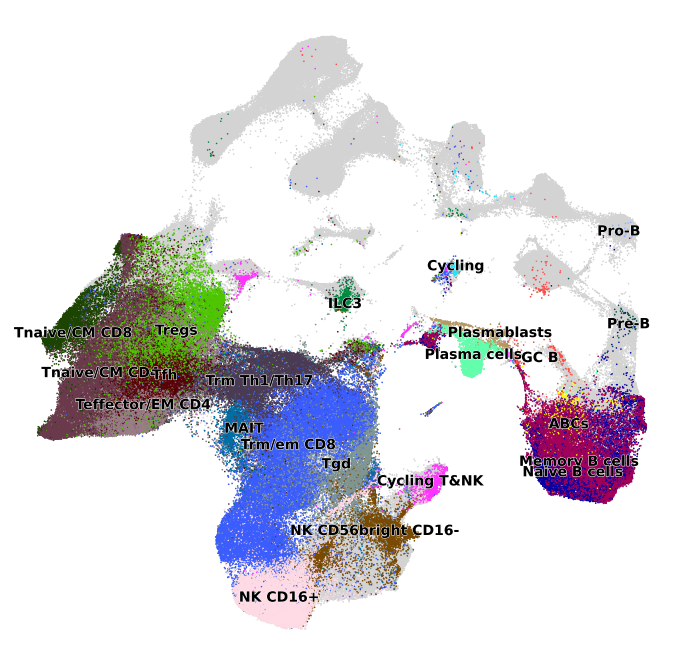

In [21]:
scv.pl.umap(merged_adata, color=["annotation_query_pl"], 
            size=10, 
            palette=sc.pl.palettes.godsnot_102,
            legend_loc="on data", groups=anno_labels, title="", 
            legend_fontsize=14, 
#             save="anno_query.png"
           )

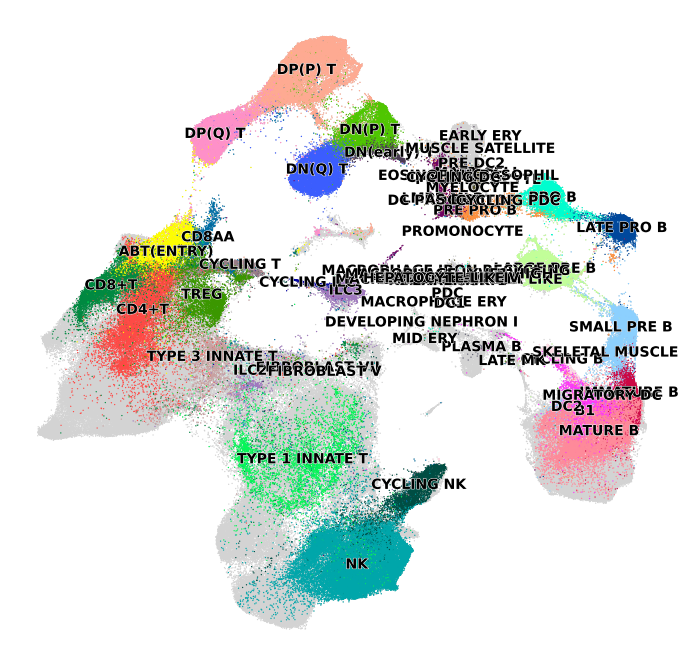

In [22]:
anno_labels = merged_adata.obs["annotation_reference"][merged_adata.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["PROGENITORS"]]

scv.pl.umap(merged_adata, color=["annotation_reference"], size=7, legend_loc="on data", groups=anno_labels, 
            legend_fontsize=14,
            title="",
#            save="anno_reference.png"
           )

In [ ]:
def _compute_invivoVSinvitro_distance(merged_adata, 
                                      q_cl, ## query cluster
                                      r_cl, ## reference cluster
                                      q_obs = 'annotation_query',
                                      r_obs = 'annotation_reference',
                                     ):
    keep_invitro_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[q_obs] == q_cl)
    keep_invivo_cells = (merged_adata.obs['dataset'] == 'reference') & (merged_adata.obs[r_obs] == r_cl)

    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invivo = X_dims[keep_invivo_cells,:]
    X_dims_invitro = X_dims[keep_invitro_cells,:]
    dmat = scipy.spatial.distance.cdist( X_dims_invitro, X_dims_invivo, metric='euclidean')
    min_dist = np.min(dmat, 1)
    min_dist = map_query_utils._scArches_adjusted_dist(min_dist)
    min_dist_df = pd.DataFrame(min_dist, columns=['min_dist'])
    min_dist_df['ref_population'] = r_cl
    min_dist_df['query_population'] = q_cl 
    min_dist_df['cell_barcode'] = merged_adata.obs_names[keep_invitro_cells]
    return(min_dist_df)

def _compute_within_distance(merged_adata, 
                                      q_cl, ## query cluster
                                      q_obs = 'annotation_query',
                                     ):
    keep_invitro_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[q_obs] == q_cl)
    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invitro = X_dims[keep_invitro_cells,:]
    mean_dist = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X_dims_invitro, metric='cosine')).min()
    return(mean_dist)

ref_cts = anno_groups_dict['NK/T CELLS']
que_cts = merged_adata.obs["annotation_query"].unique().dropna()

ct_distances_df = pd.DataFrame()
for r in ref_cts:
    for q in que_cts:
        d = _compute_invivoVSinvitro_distance(merged_adata, q_cl=q, r_cl=r)
        ct_distances_df = pd.concat([ct_distances_df, d])

### Transfer labels

In [15]:
# # min_ref_neighbors = adata.uns["neighbors"]["params"]["n_neighbors"]/10
# missing_anno = merged_adata.obs["dataset"] == "query"

# ## Find neighbors of cells with conflicting annotation
# knn_graph = merged_adata.obsp['distances']
# knn_graph_query = knn_graph[missing_anno,:]
# # knn_graph_query[knn_graph_query.nonzero()] = 1

In [18]:
def predict_label2(merged_adata, anno_col = 'annotation_reference', k=50, min_score = 0.5):
    '''
    Predict annotation labels for query cells based on k-NNs in the reference data
    '''
    import time
    from scipy.spatial import cKDTree

    ## Extract embedding
    X_emb = merged_adata.obsm["X_scvi"].copy()

    is_query = merged_adata.obs["dataset"] == "query"
    is_reference = merged_adata.obs["dataset"] == "reference"

    X_emb_ref = X_emb[is_reference,:]
    X_emb_que = X_emb[is_query,:]

    ## Find nearest neighbors in reference
    k1=k2=k
    data_query = X_emb_que
    data_ref = X_emb_ref
    start = time.time()
    k_index_ref = cKDTree(data_ref).query(x=data_query, k=k1, n_jobs=5)[1]
    end = time.time()
    print(end - start)

    knn_mat = np.zeros(shape=[sum(is_query),sum(is_reference)])
    for i in range(k_index_ref.shape[0]):
        knn_mat[i, k_index_ref[i]] = 1

    ## Subset to reference cells that have are NN to at least one query cell
    keep_ref_ixs = np.unique(k_index_ref.ravel())
    keep_ref_ixs.sort()
    small_knn_mat = knn_mat[:,keep_ref_ixs]

    ## Make dummy matrix of annotations
    annos = merged_adata[is_reference].obs[anno_col][keep_ref_ixs].copy()
    dummy_df = pd.get_dummies(annos)
    dummy_mat = dummy_df.values

    ## Sum number of neighbors with each annotation
    new_anno = small_knn_mat.dot(dummy_mat)

    ## Find top scorers
    n_neighbors = np.array(small_knn_mat.sum(1)).flatten()
    n_neighbors_ref = new_anno.sum(axis=1)
    new_anno_prob = new_anno.T/n_neighbors_ref
    new_anno_prob[np.isnan(new_anno_prob)] = 0
    best_label = dummy_df.columns[new_anno_prob.argmax(0)].values
    best_label_score = new_anno_prob.max(0)
    best_label = best_label.astype('str')

    ## Call low confidence if probability is < min_score
    best_label_all = best_label.copy()
    best_label[best_label_score <= min_score] = "low_confidence"

    ## Save output in place
    del merged_adata.obs['predicted_anno'] 
    merged_adata.obs['predicted_anno'] = np.nan
    merged_adata.obs['predicted_anno_unfiltered'] = np.nan
    merged_adata.obs['predicted_anno_prob'] = np.nan
    merged_adata.obs.loc[is_query,'predicted_anno'] = best_label
    merged_adata.obs.loc[is_query,'predicted_anno_unfiltered'] = best_label_all
    merged_adata.obs.loc[is_query,'predicted_anno_prob'] = best_label_score

---

In [19]:
smp_merged_adata = sc.pp.subsample(merged_adata, fraction=0.25, copy=True)

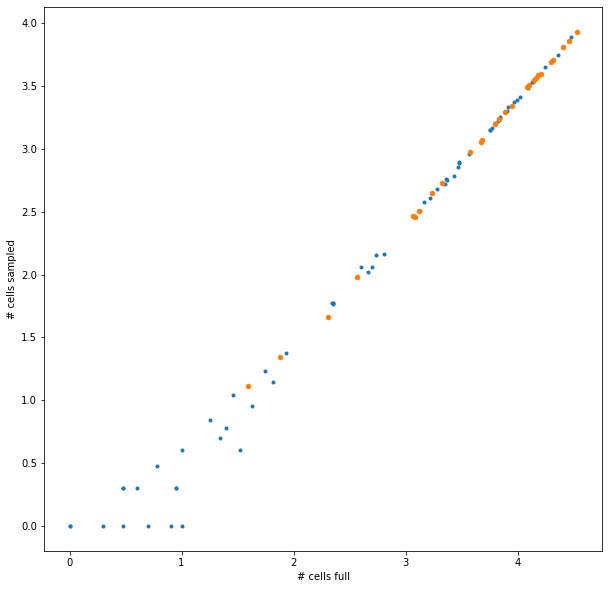

In [38]:
## Check cell numbers 
df = pd.concat([smp_merged_adata.obs.groupby('annotation_reference').size(), merged_adata.obs.groupby('annotation_reference').size()], 1)
plt.plot(np.log10(df[1]), np.log10(df[0]), '.', label='reference anno');
df = pd.concat([smp_merged_adata.obs.groupby('annotation_query').size(), merged_adata.obs.groupby('annotation_query').size()], 1)
sns.set_context('talk')
plt.plot(np.log10(df[1]), np.log10(df[0]), '.', label='query anno');
plt.xlabel('# cells full');plt.ylabel('# cells sampled');

In [39]:
smp_merged_adata.obs["annotation_reference"] = smp_merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
if 'predicted_anno' in smp_merged_adata.obs.columns:
    smp_merged_adata.obs.drop('predicted_anno', 1, inplace=True)
map_query_utils.predict_label2(smp_merged_adata, anno_col="annotation_reference")

16.2437002658844


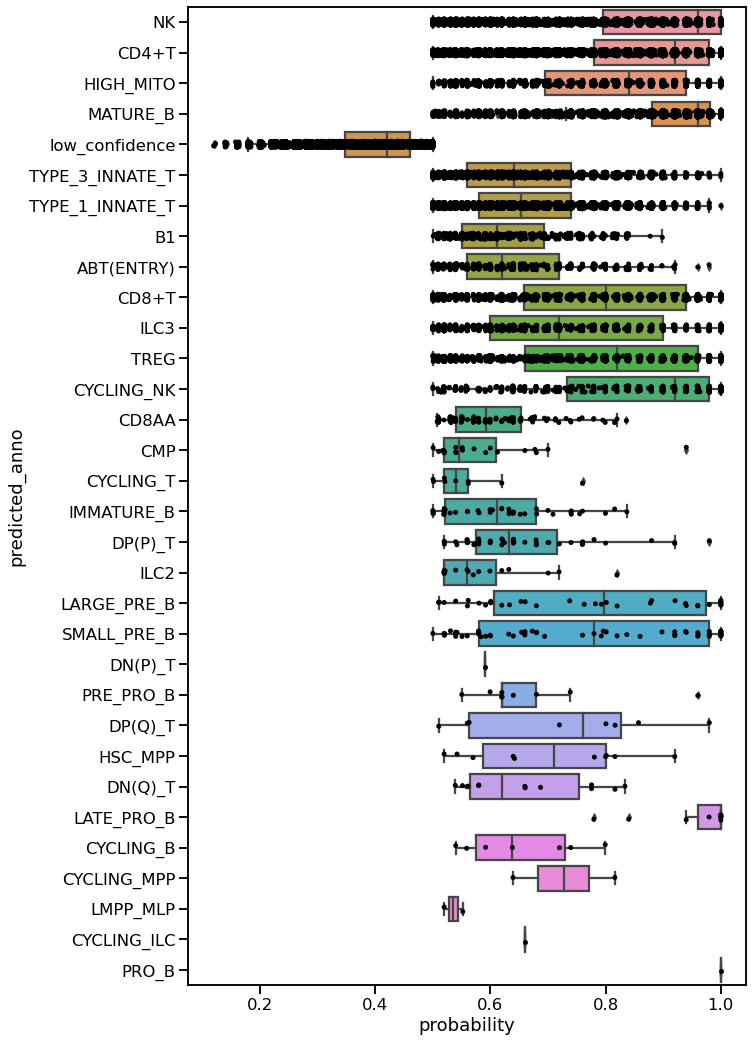

In [40]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(smp_merged_adata)

In [41]:
sns.set_context("talk")
query_anno_col="annotation_query"

query_obs = smp_merged_adata.obs_names[smp_merged_adata.obs.dataset == "query"]
empty_query = query_obs[smp_merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = smp_merged_adata[~smp_merged_adata.obs_names.isin(empty_query)].copy()
merged_adata_clean.obs[query_anno_col] = merged_adata_clean.obs[query_anno_col].astype("str")

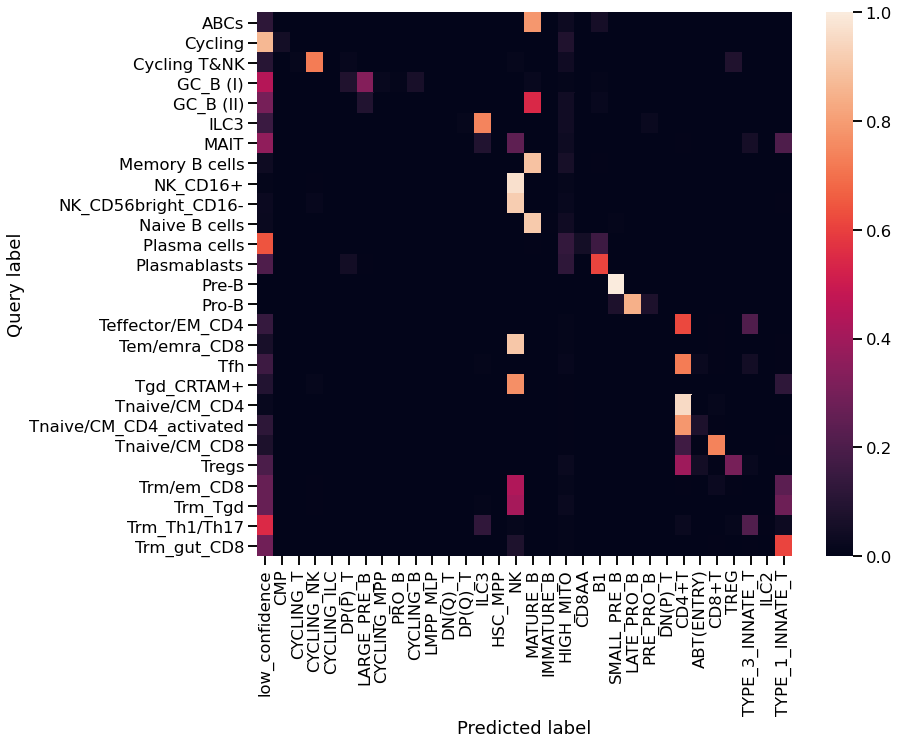

In [43]:
plt.rcParams["figure.figsize"] = [12,10]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)

### Quantify matching between datasets

In [48]:
import time
## Calculate distance of a query cell to closest cell of 
# predicted annotation

def _compute_min_dist2predicted_anno(merged_adata, r_cl,
#                                      q_cell,
                                     r_obs = 'annotation_reference',
                                     pred_anno_obs = 'predicted_anno_unfiltered'
                                    ):
    from scipy.spatial import cKDTree
    # Pick reference cluster 
    keep_ref_cells = (merged_adata.obs['dataset'] == 'reference') & (merged_adata.obs[r_obs] == r_cl)
    keep_query_cells = (merged_adata.obs['dataset'] == 'query') & (merged_adata.obs[pred_anno_obs] == r_cl)

    ## Calculate distance of query cell to all reference
    # cells in cluster
    X_dims = merged_adata.obsm['X_scvi'].copy()
    X_dims_invivo = X_dims[keep_ref_cells,:]
    X_dims_invitro = X_dims[keep_query_cells,:]
    k_ref = cKDTree(X_dims_invivo).query(x=X_dims_invitro, k=1, n_jobs=5)
    min_dists = k_ref[0]
    min_dists_df = pd.DataFrame(zip(merged_adata.obs_names[keep_query_cells],min_dists), columns=['query_cell', 'min_distance2pred'])
    return(min_dists_df)

start = time.time()
smp_merged_adata.obs['min_distance2pred'] = np.nan
counter = 0
is_query = smp_merged_adata.obs["dataset"] == "query"
is_reference = smp_merged_adata.obs["dataset"] == "reference"
for r_cl in smp_merged_adata.obs['predicted_anno_unfiltered'].unique():
    counter += 1
    min_dists_df = _compute_min_dist2predicted_anno(smp_merged_adata, r_cl)
    smp_merged_adata.obs.loc[min_dists_df.query_cell, 'min_distance2pred'] = min_dists_df.min_distance2pred.values
    print(counter)
## Normalize w gaussian kernel
smp_merged_adata.obs.loc[is_query, 'min_distance2pred'] = map_query_utils._scArches_adjusted_dist(smp_merged_adata.obs.loc[is_query, 'min_distance2pred'].astype('float').values)
end = time.time()
print(end-start)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
2.1401991844177246


### Combined similarity & confusion matrix

In [65]:
q_df = smp_merged_adata[smp_merged_adata.obs['dataset'] == 'query'].obs[["min_distance2pred", "predicted_anno", "annotation_query", 'organ_code']]
q_df = q_df[~q_df.annotation_query.isna()]
q_df.annotation_query = q_df.annotation_query.astype('str')
q_df.min_distance2pred = q_df.min_distance2pred.astype('float')

In [66]:
query_anno_group_lymphoid = {
    "B cells":[x for x in q_df.annotation_query.unique() if x.endswith("B") or "GC_B" in x or x=="B_prog" or "Plasma" in x or 'MemB' in x],
    "NK cells":[x for x in q_df.annotation_query.unique() if x.startswith("NK")],
    "other":[x for x in q_df.annotation_query.unique() if 'doublets' in x],
    }

query_anno_group_lymphoid['T cells'] = [x for x in q_df.annotation_query.unique() if x not in sum(query_anno_group_lymphoid.values(),[])]
query_anno_group_lymphoid_rev = {x:g for g,a in query_anno_group_lymphoid.items() for x in a}

ref_anno_group_lymphoid = {
    "NK cells":[x for x in q_df.predicted_anno.unique() if x.endswith("NK")],
    "ILCs":[x for x in q_df.predicted_anno.unique() if x.startswith("ILC")],
    "B cells":[x for x in q_df.predicted_anno.unique() if x.endswith("B") or x=="B1"],
    "T cells":[x for x in q_df.predicted_anno.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA" or x=="TREG"],
    'low_confidence':['low_confidence']
    }

ref_anno_group_lymphoid['other'] = [x for x in q_df.predicted_anno.unique() if x not in sum(ref_anno_group_lymphoid.values(),[])]
ref_anno_group_lymphoid_rev = {x:g for g,a in ref_anno_group_lymphoid.items() for x in a}

q_df['annotation_query_group'] = [query_anno_group_lymphoid_rev[x] for x in q_df['annotation_query']]
q_df['predicted_anno_group'] = [ref_anno_group_lymphoid_rev[x] for x in q_df['predicted_anno']]

`summarise()` has grouped output by 'predicted_anno', 'annotation_query', 'annotation_query_group', 'predicted_anno_group'. You can override using the `.groups` argument.


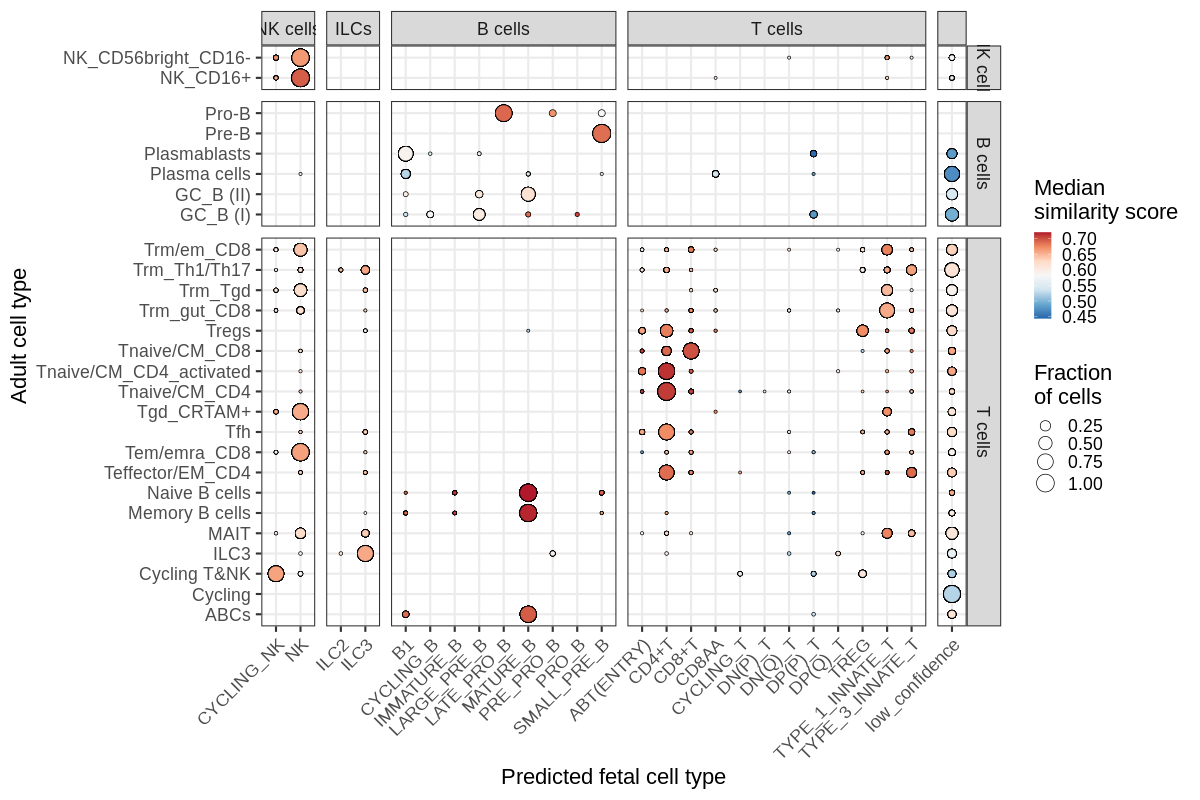

In [79]:
%%R -i q_df -h 800 -w 1200 
q_df %>%
    group_by(annotation_query) %>%
    mutate(tot_cells=n()) %>%
    ungroup() %>%
    group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
    summarise(frac_cells=n()/tot_cells, median_sim_score=median(min_distance2pred)) %>%
    ungroup() %>%
    filter(annotation_query_group != 'other' & predicted_anno_group != 'other' ) %>%
    mutate(annotation_query_group=factor(annotation_query_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells'))) %>%
    mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confidence", '', predicted_anno_group)) %>%
    mutate(predicted_anno_group=factor(predicted_anno_group, levels=c('NK cells', 'ILCs', 'B cells', 'T cells', ''))) %>%
    ggplot(aes(predicted_anno, annotation_query)) +
    scale_size(range=c(1,8), name="Fraction\nof cells") +
    geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
    scale_fill_distiller(palette="RdBu", direction=-1, name='Median\nsimilarity score') +
    facet_grid(annotation_query_group~as.factor(predicted_anno_group), space="free", scales='free') +
    xlab("Predicted fetal cell type") + ylab("Adult cell type") +
    theme_bw(base_size=22) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) 
#     ggsave(paste0(figdir, "adult_confusion_similarity_dotplot.pdf"), width=15, height=10)

In [80]:
## Save for future plotting
q_df.to_csv('/nfs/team205/ed6/data/Fetal_immune/panimmune_full_LYMPHOID_query.mapped2LYMPHOID_NEW.confusion_table.csv')

### Save outputs

In [12]:
# merged_adata.obs['min_distance2pred'] = merged_adata.obs['min_distance2pred'].astype('float')
# merged_adata.write_h5ad(data_dir + merged_adata_file)
# merged_adata = sc.read_h5ad(data_dir + merged_adata_file)

## Compare with _de novo_ integration

In [227]:
X_scVI_denovo = np.load('/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/merged_fetal_adult.LYMPHOID_NEW.scVI_out.npy')

In [228]:
X_scVI_denovo.shape

(504242, 20)

In [229]:
merged_adata_denovo = sc.read_h5ad('/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/merged_fetal_adult.LYMPHOID_NEW.h5ad')

In [230]:
merged_adata_denovo.obsm['X_scvi'] = X_scVI_denovo.copy()

In [231]:
k_neighbors = 30
sc.pp.neighbors(merged_adata_denovo, n_neighbors=k_neighbors, use_rep="X_scvi")
print("Running UMAP...\n")
sc.tl.umap(merged_adata_denovo, min_dist = 0.01, spread = 2)

Running UMAP...



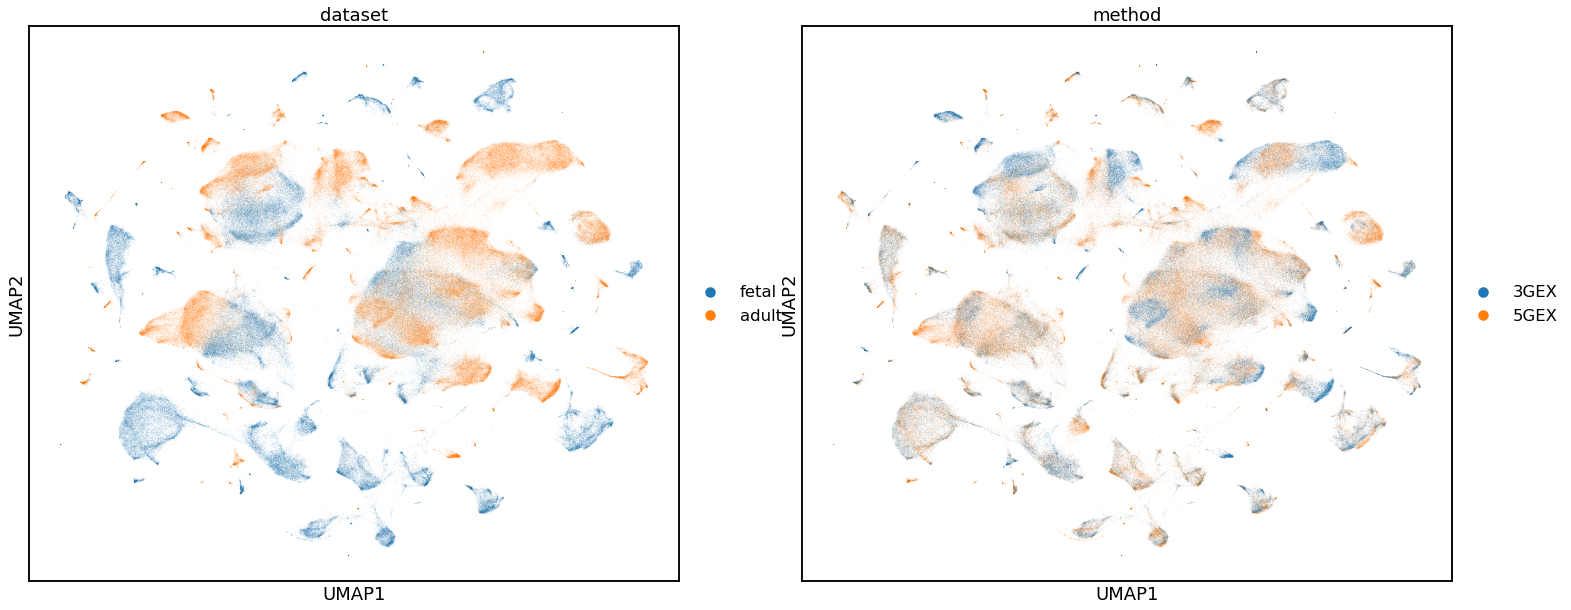

In [232]:
sc.pl.umap(merged_adata_denovo, color=['dataset', 'method'])

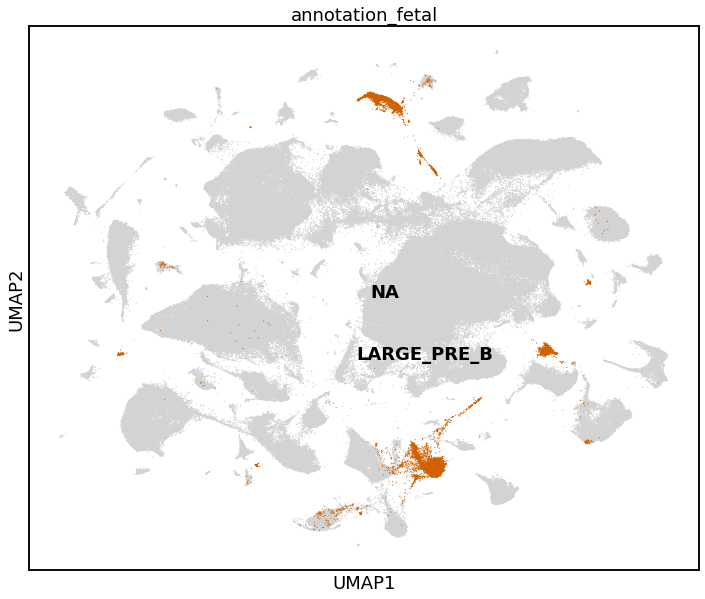

In [233]:
sc.pl.umap(merged_adata_denovo, color=['annotation_fetal'], legend_loc='on data', size=5,
          groups=['LARGE_PRE_B'])

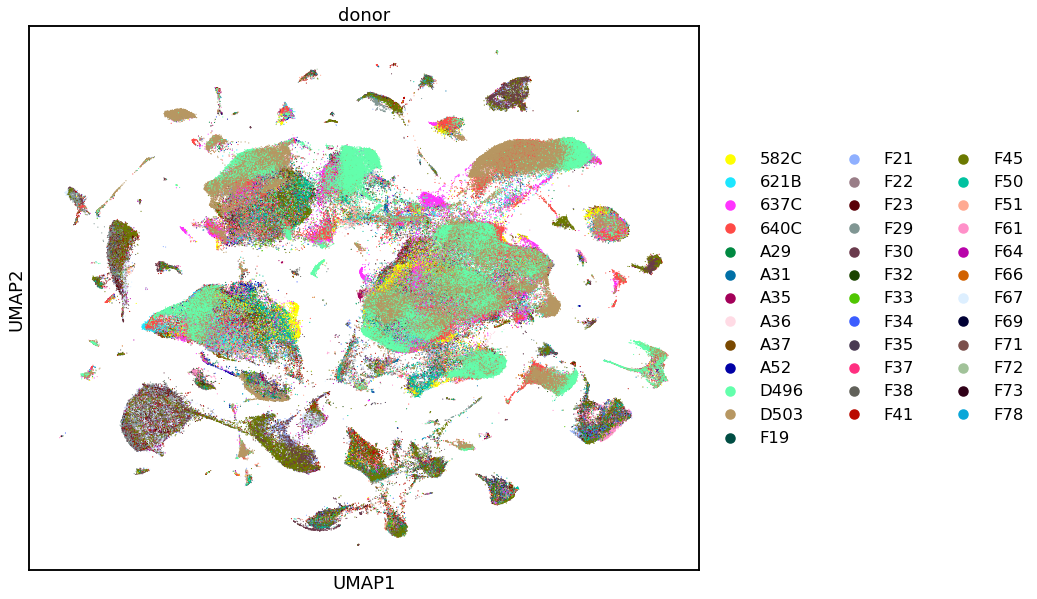

In [234]:
sc.pl.umap(merged_adata_denovo, color=['donor'], size=5)

## Compare with online learning

In [143]:
def _merge_query_and_reference(
    query_h5ad_file,
    split,
    ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/',
    timestamp = '20210429'):
    '''
    Read output from query mapping and reference data and merges them in one anndata
    
    Params:
    ------
    - query_h5ad_file: h5ad file storing mapped query anndata
    - split: data split ID
    - ref_data_dir: folder containing reference data
    - timestamp: dataset timestamp
    '''
    query_adata_mapped = sc.read_h5ad(query_h5ad_file)
    query_adata_full = sc.read_h5ad(query_h5ad_file.split(".mapped2")[0] + ".h5ad") ## To add genes that are not used in scVI
    query_adata_full.obsm["X_scvi"] = query_adata_mapped.obsm["X_scvi"].copy()
    query_adata_full.uns["_scvi"] = query_adata_mapped.uns["_scvi"].copy()
    
    ## Read reference
    ref_adata = sc.read_h5ad(ref_data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(t=timestamp, s=split))
    ref_embedding = np.load(ref_data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.scVI_out.V2.npy'.format(t=timestamp, s=split))
    ref_adata.obsm["X_scvi"] = ref_embedding
    ref_adata.var_names = ref_adata.var.GeneID

    concat_adata = anndata.concat([ref_adata, query_adata_full], axis=0,
                                  label="dataset", keys=["reference", "query"],
                                  join="outer", merge="unique", uns_merge="unique")
    concat_adata.obs_names = concat_adata.obs_names + "-" + concat_adata.obs["dataset"].astype("str")
    return(concat_adata)

def _add_all_query_genes(merged_adata, query_adata_full):
    if not any(merged_adata.var_names.isin(query_adata_full.var_names)):
        raise ValueError("var_names don't match between query and merged AnnData")

    if not any(query_adata_full.obs_names.str.endswith("-query")):
        query_adata_full.obs_names = query_adata_full.obs_names + "-query"

    ## Do the merge
    full_merged_adata = anndata.concat([merged_adata, query_adata_full], axis=1, join="outer", merge="unique", uns_merge="unique")

    ## Check that the number of obs is right
    if not full_merged_adata.n_obs == merged_adata.n_obs:
        raise AssertionError("The number of obs doesn't match, something is wrong in your join")

    ## Check that you have more expression vals than before
    one_query_cell = query_adata_full.obs_names[10]
    if not len(full_merged_adata[one_query_cell].X.nonzero()[0]) > len(merged_adata[one_query_cell].X.nonzero()[0]):
        raise AssertionError("You have less or the same expression values for query cells than before. Are you sure that query_adata_full is the dataset before feature selection?")

    return(full_merged_adata)


In [145]:
query_h5ad_file = ref_data_dir+'panimmune_full_LYMPHOID_query.mapped2LYMPHOID_NEW.nonzero_w_decay.h5ad'
merged_adata = _merge_query_and_reference(query_h5ad_file, split, ref_data_dir=ref_data_dir)
query_adata_full = sc.read_h5ad(query_h5ad_file.split(".mapped2")[0] + ".h5ad") ## To add genes that are not used in scVI
# merged_adata = _add_all_query_genes(merged_adata, query_adata_full)

## Compute UMAP
print("Running KNN search...\n")
sc.pp.neighbors(merged_adata, n_neighbors=k_neighbors, use_rep="X_scvi")
print("Running UMAP...\n")
sc.tl.umap(merged_adata, min_dist = 0.01, spread = 2)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Running KNN search...

Running UMAP...



In [188]:
ref_obs = merged_adata[merged_adata.obs['dataset']=='reference'].obs_names.str.strip('-reference')
merged_adata.obs['annotation_reference'] = np.nan
merged_adata.obs.loc[ref_obs+'-reference', 'annotation_reference'] = anno_obs.loc[ref_obs, 'anno_lvl_2_final_clean'].values.astype('str')
merged_adata.obs.loc[ref_obs+'-reference', 'method'] = anno_obs.loc[ref_obs, 'method'].values.astype('str')
merged_adata.obs['donor'] = merged_adata.obs['donor'].astype('str')
merged_adata.obs.loc[ref_obs+'-reference', 'donor'] = anno_obs.loc[ref_obs, 'donor'].values.astype('str')

In [194]:
merged_adata_denovo.var

AnnData object with n_obs × n_vars = 504242 × 21794
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'organ_code', 'donor', 'method', 'Category', 'dataset', 'organ', 'gestational_age', 'annotation_fetal'
    var: 'GeneID', 'GeneName', 'gene_names', 'highly_variable', 'gene_ids', 'feature_types', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'umap', 'dataset_colors', 'method_colors', 'annotation_fetal_colors', 'Category_colors', 'donor_colors'
    obsm: 'X_umap', 'X_scvi'
    obsp: 'distances', 'connectivities'

In [173]:
keep_cts = merged_adata.obs['annotation_reference'].value_counts().index[merged_adata.obs['annotation_reference'].value_counts() > 10]

... storing 'donor' as categorical
... storing 'annotation_reference' as categorical


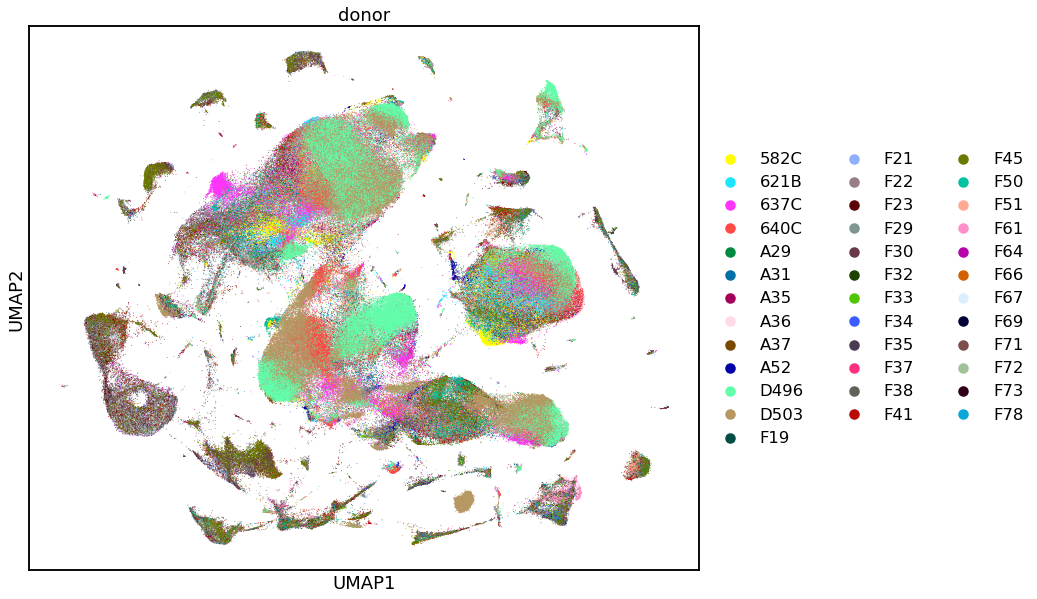

In [189]:
sc.pl.umap(merged_adata, color=['donor'], size=3, 
#            groups=keep_cts.tolist(),
          )

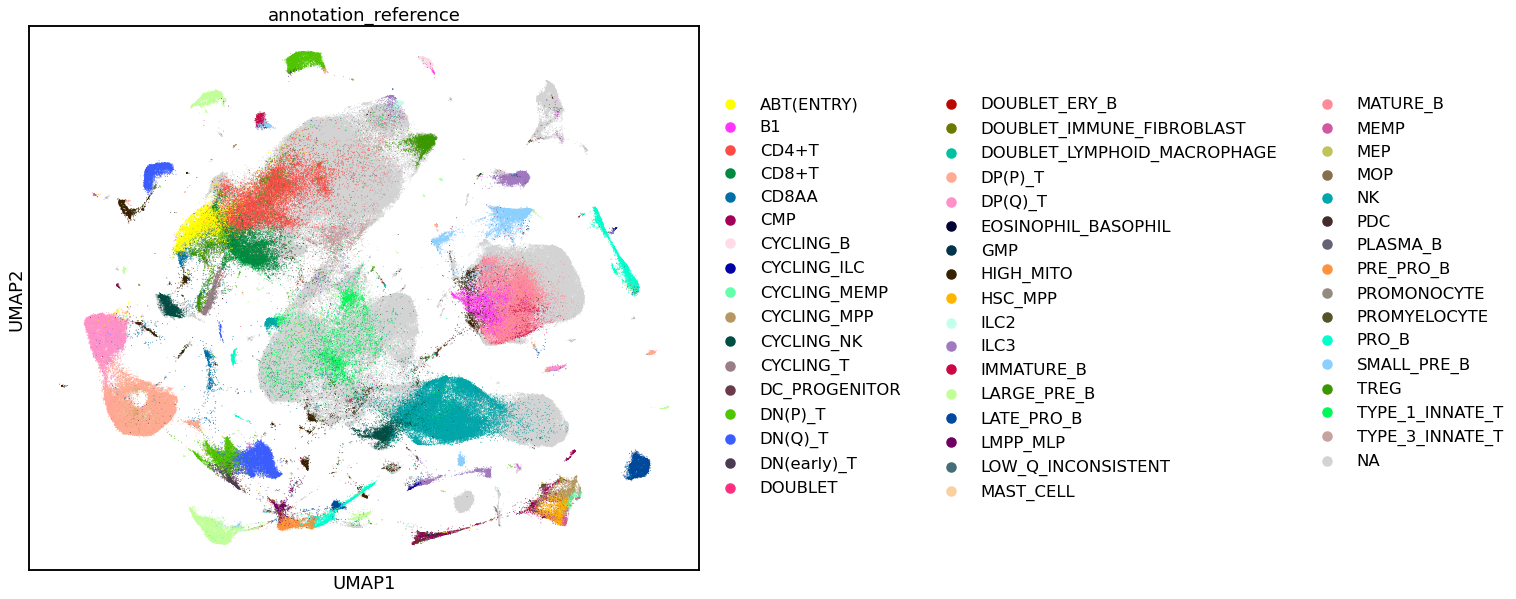

In [195]:
sc.pl.umap(merged_adata, color=['annotation_reference'], size=3, 
           groups=keep_cts.tolist(),
#            groups=["DN(P)_T", "LARGE_PRE_B"]
          )

In [204]:
qc_obs,qc_vars = sc.pp.calculate_qc_metrics(merged_adata_denovo, log1p=False)

In [206]:
qc_obs

n_genes_by_counts  total_counts  \
FCAImmP7579224-CTAATGGCACTGTGTA-fetal               5200       49847.0   
FCAImmP7579224-ATTATCCAGAGAACAG-fetal               4808       39019.0   
FCAImmP7579224-GACGGCTAGCCACCTG-fetal               5030       37050.0   
FCAImmP7579224-GCGGGTTGTCCGAGTC-fetal               4471       32467.0   
FCAImmP7579224-AGTTGGTAGTGTTAGA-fetal               4383       30336.0   
...                                                  ...           ...   
CZINY-0112_TTTGGTTAGGCCACTC-adult                   1708        4877.0   
CZINY-0112_TTTGGTTCACAAAGTA-adult                   2013        7147.0   
CZINY-0112_TTTGGTTTCCATCACC-adult                   1639        4471.0   
CZINY-0112_TTTGTTGCAGCGGTTC-adult                   1546        4645.0   
CZINY-0112_TTTGTTGGTGCGACAA-adult                   1387        3287.0   

                                       pct_counts_in_top_50_genes  \
FCAImmP7579224-CTAATGGCACTGTGTA-fetal                   38.082533   
FCAImmP7579224-ATTATCCAGAGAACAG-fetal                   42.510059   
FCAImmP7579224-GACGGCTAGCCACCTG-fetal                   31.840756   
FCAImmP7579224-GCGGGTTGTCCGAGTC-fetal                   34.256322   
FCAImmP7579224-AGTTGGTAGTGTTAGA-fetal                   35.452927   
...                                                           ...   
CZINY-0112_TTTGGTTAGGCCACTC-adult                       37.728112   
CZINY-0112_TTTGGTTCACAAAGTA-adult                       41.318036   
CZINY-0112_TTTGGTTTCCATCACC-adult                       35.786178   
CZINY-0112_TTTGTTGCAGCGGTTC-adult                       38.837460   
CZINY-0112_TTTGTTGGTGCGACAA-adult                       35.077578   

                                       pct_counts_in_top_100_genes  \
FCAImmP7579224-CTAATGGCACTGTGTA-fetal                    54.432564   
FCAImmP7579224-ATTATCCAGAGAACAG-fetal                    55.162869   
FCAImmP7579224-GACGGCTAGCCACCTG-fetal                    46.585695   
FCAImmP7579224-GCGGGTTGTCCGAGTC-fetal                    48.449195   
FCAImmP7579224-AGTTGGTAGTGTTAGA-fetal                    50.379088   
...                                                            ...   
CZINY-0112_TTTGGTTAGGCCACTC-adult                        48.410908   
CZINY-0112_TTTGGTTCACAAAGTA-adult                        56.219393   
CZINY-0112_TTTGGTTTCCATCACC-adult                        47.282487   
CZINY-0112_TTTGTTGCAGCGGTTC-adult                        53.369214   
CZINY-0112_TTTGTTGGTGCGACAA-adult                        46.851232   

                                       pct_counts_in_top_200_genes  \
FCAImmP7579224-CTAATGGCACTGTGTA-fetal                    65.689008   
FCAImmP7579224-ATTATCCAGAGAACAG-fetal                    64.696686   
FCAImmP7579224-GACGGCTAGCCACCTG-fetal                    57.578947   
FCAImmP7579224-GCGGGTTGTCCGAGTC-fetal                    59.953183   
FCAImmP7579224-AGTTGGTAGTGTTAGA-fetal                    61.850607   
...                                                            ...   
CZINY-0112_TTTGGTTAGGCCACTC-adult                        59.073201   
CZINY-0112_TTTGGTTCACAAAGTA-adult                        66.223590   
CZINY-0112_TTTGGTTTCCATCACC-adult                        58.152539   
CZINY-0112_TTTGTTGCAGCGGTTC-adult                        63.961249   
CZINY-0112_TTTGTTGGTGCGACAA-adult                        57.894737   

                                       pct_counts_in_top_500_genes  
FCAImmP7579224-CTAATGGCACTGTGTA-fetal                    76.066764  
FCAImmP7579224-ATTATCCAGAGAACAG-fetal                    75.263333  
FCAImmP7579224-GACGGCTAGCCACCTG-fetal                    69.306343  
FCAImmP7579224-GCGGGTTGTCCGAGTC-fetal                    72.193304  
FCAImmP7579224-AGTTGGTAGTGTTAGA-fetal                    73.196862  
...                                                            ...  
CZINY-0112_TTTGGTTAGGCCACTC-adult                        73.487800  
CZINY-0112_TTTGGTTCACAAAGTA-adult                        76.885406  
CZINY-0112_TTTGGTT

In [220]:
merged_adata_denovo.obs['n_genes_by_counts'] = qc_obs['n_genes_by_counts']
merged_adata_denovo.obs['total_counts'] = qc_obs['total_counts']
merged_adata_denovo.obs['pct_counts_in_top_100_genes'] = qc_obs['pct_counts_in_top_100_genes']

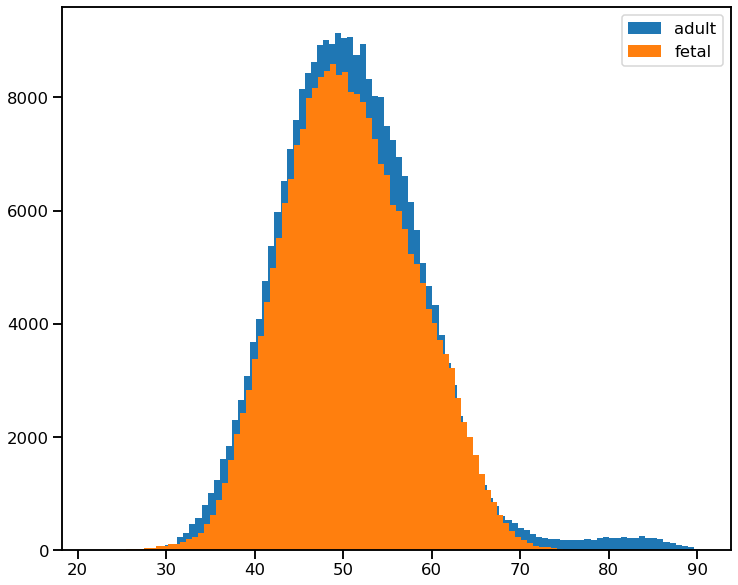

In [221]:
plt.hist(merged_adata_denovo[merged_adata_denovo.obs['dataset']== 'adult'].obs['pct_counts_in_top_100_genes'], bins=100, label='adult');
plt.hist(merged_adata_denovo[merged_adata_denovo.obs['dataset']== 'fetal'].obs['pct_counts_in_top_100_genes'], bins=100, label='fetal');
plt.legend()

## Compare with adult-only integration

In [245]:
X_scVI_adult = np.load('/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/panimmune_full.LYMPHOID.scVI_out.npy')

In [246]:
query_adata_full.obsm['X_scVI'] = X_scVI_adult.copy()

In [250]:
k_neighbors = 30
sc.pp.neighbors(query_adata_full, n_neighbors=k_neighbors, use_rep="X_scVI")
print("Running UMAP...\n")
sc.tl.umap(query_adata_full, min_dist = 0.01, spread = 2)

Running UMAP...



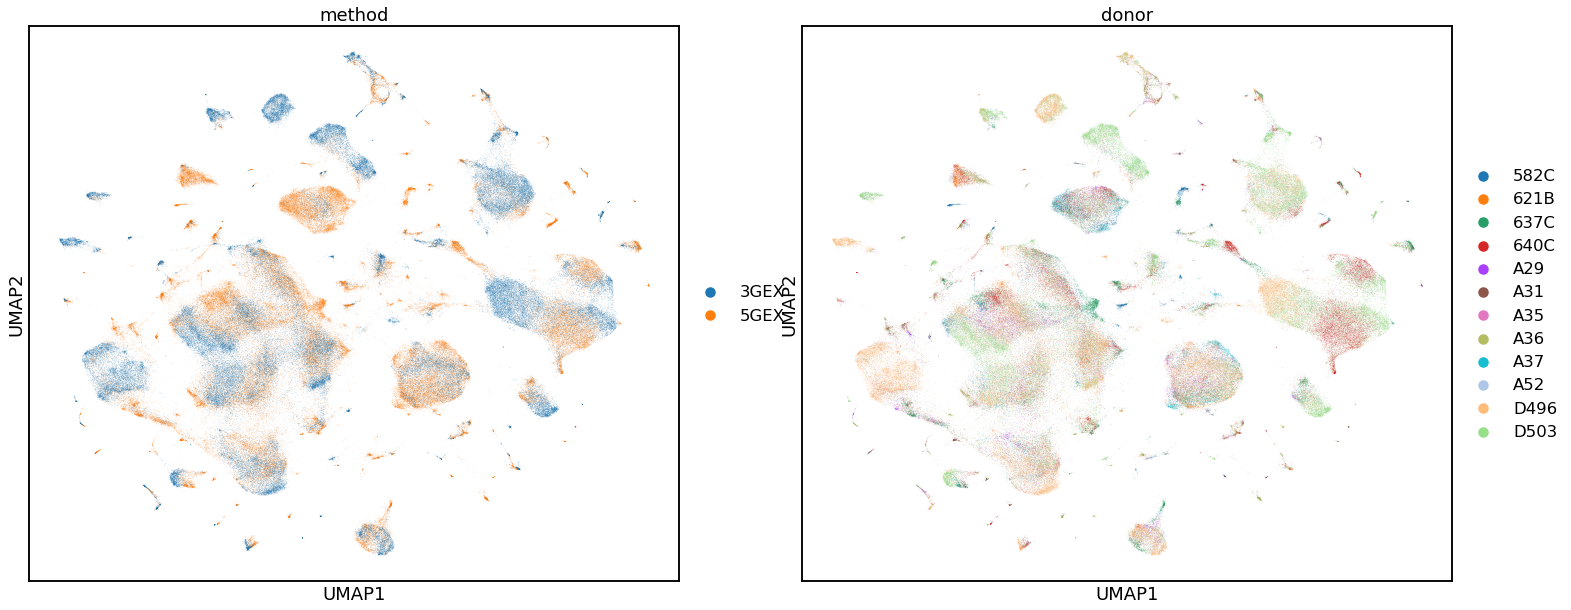

In [251]:
sc.pl.umap(query_adata_full, color=['method', 'donor'])

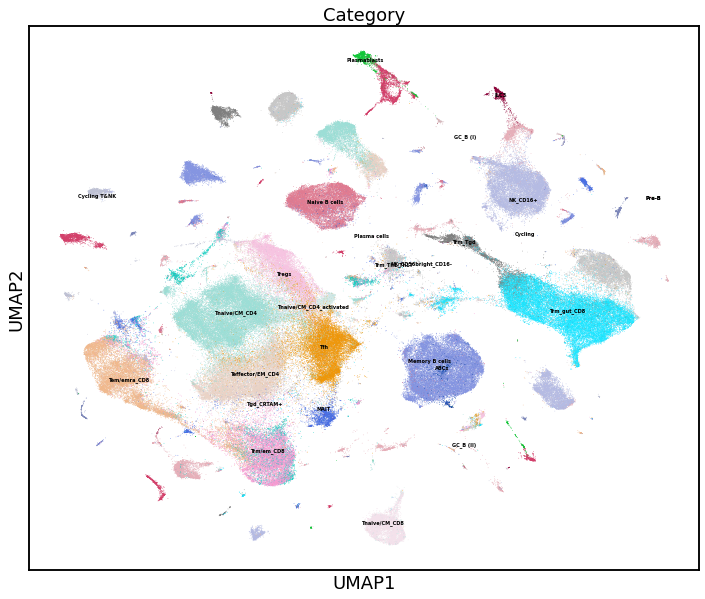

In [256]:
sc.pl.umap(query_adata_full, color=['Category'], size=2, legend_loc='on data', legend_fontsize=5)

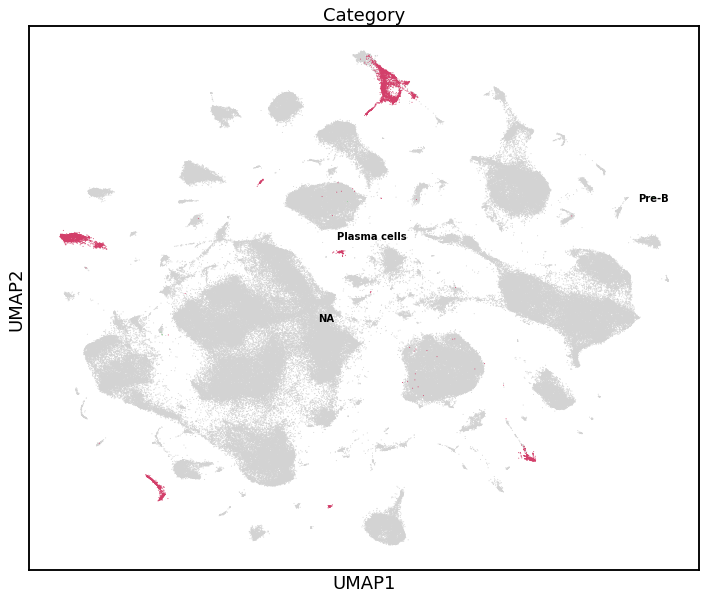

In [258]:
sc.pl.umap(query_adata_full, color=['Category'], size=4, legend_loc='on data', legend_fontsize=10, groups=["Plasma cells", 'Pre-B'])


---

### Plot marker expression in mature B cells

In [35]:
merged_adata.var_names = merged_adata.var['GeneName'].astype('str').values.copy()

In [37]:
merged_adata.var_names_make_unique()

In [60]:
sc.pp.normalize_total(merged_adata,target_sum=10e04)

In [61]:
sc.pp.log1p(merged_adata)

In [62]:
query_ixs = merged_adata.obs['annotation_query'].isin(['GC_B (I)', 'GC_B (II)', "Naive B cells", "Memory B cells"])
ref_ixs = merged_adata.obs['annotation_reference']=="MATURE_B"

pl_adata = merged_adata[ ref_ixs | query_ixs ].copy()
pl_adata.obs['pl_annotation'] = np.nan
pl_adata.obs.loc[ref_ixs,'pl_annotation'] = pl_adata.obs.loc[ref_ixs, 'dataset'].astype('str') + "_" + pl_adata.obs.loc[ref_ixs, 'annotation_reference'].astype('str')
pl_adata.obs.loc[query_ixs,'pl_annotation'] = pl_adata.obs.loc[query_ixs, 'dataset'].astype('str') + "_" + pl_adata.obs.loc[query_ixs, 'annotation_query'].astype('str')

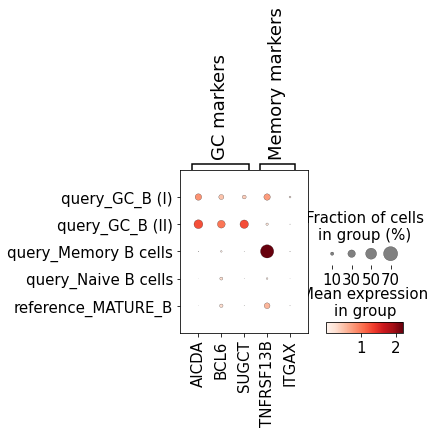

In [72]:
b_cell_markers = { ## Plucked from Conde et al.
    'GC markers':['AICDA','BCL6','SUGCT'],
    'Memory markers': ['TNFRSF13B','ITGAX']
}
plt.rcParams.update({'font.size': 18})
sc.pl.dotplot(pl_adata,
              b_cell_markers,
              groupby='pl_annotation', figsize=[4,3], save='matureB_expression.pdf')


## Mapping validation metrics

In [12]:
query_mapped_adata = merged_adata[merged_adata.obs['dataset'] == 'query'].copy()

sc.pp.neighbors(query_mapped_adata, use_rep='X_scvi', n_neighbors=30)

In [16]:
sc.tl.leiden(query_mapped_adata, resolution=0.5)

In [17]:
query_mapped_adata.obs['leiden'] = query_mapped_adata.obs['leiden'].astype("str")
query_mapped_adata.obs['annotation_query'] = query_mapped_adata.obs['annotation_query'].astype("str")

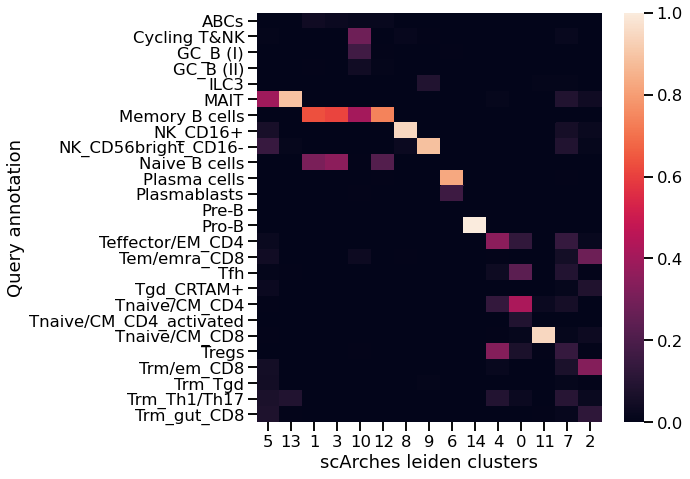

In [18]:
sns.set_context("talk")
keep_cts = query_mapped_adata.obs['annotation_query'].value_counts().index[query_mapped_adata.obs['annotation_query'].value_counts() > 10]
keep_cts = keep_cts[keep_cts!='nan']
conf_mat = sc.metrics.confusion_matrix('leiden','annotation_query', 
                                       query_mapped_adata.obs[query_mapped_adata.obs['annotation_query'].isin(keep_cts)]).T

col_order = conf_mat.idxmax(0).sort_values().index
conf_mat = conf_mat[col_order] ## Sort to have some sort of diagonal

plt.rcParams['figure.figsize'] = [10, 7]
sns.heatmap(conf_mat, xticklabels=True, yticklabels=True);
plt.xlabel("scArches leiden clusters");
plt.ylabel("Query annotation");
plt.tight_layout();
plt.savefig(figdir + 'validation_conf_mat.pdf')

In [22]:
query_mapped_adata.obs.columns

Index(['n_counts', 'n_genes', 'file', 'mito', 'doublet_scores',
       'predicted_doublets', 'name', 'sample', 'Source ID', 'sex',
       'patient no', 'organ code', 'sample ID', 'fraction_mito', 'log_counts',
       'batch', 'empty', 'bonf_pval', 'is_doublet', 'scrublet_score',
       'louvain', 'louvain_R', 'scrublet_cluster_score', 'zscore', 'bh_pval',
       'leiden', 'predicted_labels', 'over_clustering', 'majority_voting',
       'leiden5', 'leiden10', 'leiden15', 'leiden20', 'cx1_anno',
       'leiden_majority_anno', 'leiden1.5', 'anno', 'anno_mye', 'anno_T_2',
       'anno_B_v2', 'dataset', 'annotation_reference', 'annotation_query',
       'predicted_anno_prob', 'knn_sim', 'mnn_sim', 'mnn_sim_ratio',
       'precited_anno_prob', 'min_distance2pred', 'predicted_anno',
       'predicted_anno_unfiltered'],
      dtype='object')

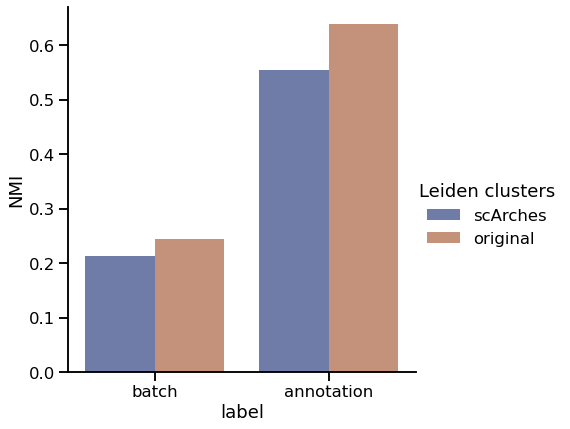

In [23]:
import sklearn
nmi_anno_old = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['annotation_query'], query_mapped_adata.obs["leiden5"])
nmi_anno_new = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['annotation_query'], query_mapped_adata.obs["leiden"])
nmi_batch_old = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['batch'], query_mapped_adata.obs["leiden10"])
nmi_batch_new = sklearn.metrics.normalized_mutual_info_score(query_mapped_adata.obs['batch'], query_mapped_adata.obs["leiden"])

df = pd.DataFrame([nmi_batch_new, nmi_batch_old,nmi_anno_new, nmi_anno_old])
df.columns = ['NMI']
df['cat'] = ['batch_scArches', 'batch_original', 'annotation_scArches', "annotation_original"]
df['Leiden clusters'] = [x[1] for x in df['cat'].str.split("_")]
df['label'] = [x[0] for x in df['cat'].str.split("_")]

sns.catplot(
    data=df, kind="bar",
    x="label", y="NMI", hue='Leiden clusters',
    ci="sd", palette="dark", alpha=.6, height=6
)
plt.savefig(figdir + 'validation_barplot.pdf')

---